# Diabetes Prediction Using ML classifers and Ensemble method

**Novelty created by:** Yichen Shi, Jingyu Wang <br>
**Summary:**  In this novelty part, we tried more classifers that didn't used in the parent paper, including Logistic Regression, Support Vector machine, Linear Discriminant Analysis, Gradient Boosting, Light Gradient Boosting and CatBoost. We further did experiments to ensemble these classifers to see if the new method could outperform the proposed method.

## Load packagaes

In [37]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings 
from sklearn.svm import SVC, NuSVC
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy import interp
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier
from lightgbm import  LGBMClassifier
from sklearn.ensemble import VotingClassifier

## Load processed data
Here, we used the parent paper's method to process the data and saved as a data file.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving processed_data.csv to processed_data.csv


In [38]:
# inspect the data
data = pd.read_csv('processed_data.csv')
data.head(5)

,Unnamed: 0,F1,F2,F3,F4,F5,F6,F7,F8,Outcome
0,0,6.0,148.0,72.0,35.000000,171.474227,33.6,-0.466809,3.912023,1
1,1,1.0,85.0,66.0,29.000000,113.606695,26.6,-1.046969,3.433987,0
2,2,8.0,183.0,64.0,32.059259,171.474227,23.3,-0.397497,3.465736,1
3,3,1.0,89.0,66.0,23.000000,94.000000,28.1,-1.789761,3.044522,0
4,5,5.0,116.0,74.0,27.094512,113.606695,25.6,-1.604450,3.401197,0


## Define the utility functions

In [39]:
Renamed_feature= []             
all_clf_res=[]                    
random_initializer=100            
n_dots=50

for i in range(8):
  Renamed_feature.append('F'+str(i+1)) 


def metrics (y_true, y_pred, probas_):

  points=n_dots*'-'
  print(points)
  fpr, tpr, thresholds = roc_curve(y_true, probas_[:, 1])
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  print("Detailed classification report for current fold:")
  print()
  print(classification_report(y_true, y_pred))
  print()
  print("Area Under ROC (AUC): {}".format(roc_auc))
  print()
  print('Confusion Matrix for current fold: ')
  print(confusion_matrix(y_true, y_pred))
  print()
  print("Accuracy for Current Fold: {}".format(accuracy_score(y_true, y_pred)))
  print()
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  return  tn, fp, fn, tp, roc_auc, fpr, tpr



def average_ROC(mean_fpr,tprs,aucs,TP,TN,FP,FN):
  sen = (np.sum(TP))/(np.sum(TP)+np.sum(FN))
  spe = (np.sum(TN))/(np.sum(TN)+np.sum(FP))

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = np.mean(aucs)
  std_auc = np.std(aucs)
  ax = plt.axes()
  ax.grid(color='lightgray', linestyle='-', linewidth=.5)
  ax.set_facecolor("white")
  
  ax.spines['bottom'].set_color('#000000')
  ax.spines['top'].set_color('#000000') 
  ax.spines['right'].set_color('#000000')
  ax.spines['left'].set_color('#000000')

  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Avg. ROC (AUC (avg $\pm$ std) = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)
  
  plt.scatter((1-spe), sen, s=80, c='r', marker='x',)
  plt.scatter(0, sen, s=80, c='r', marker='x',)
  plt.scatter((1-spe),0, s=80, c='r', marker='x',)
  plt.axhline(y=sen, color='r', linestyle='--')
  plt.axvline(x=(1-spe), color='r', linestyle='--')
  plt.text((1-spe), 0.02, "FPR={:0.3f}".format((1-spe)))
  plt.text(0.009, sen+0.05, "TPR={:0.3f}".format(sen))

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='darkgray', alpha=0.5,
                  label=r'$\pm$ 1 Standard deviation')

  plt.xticks(np.arange(0.0, 1.01, step=0.1))
  plt.yticks(np.arange(0.0, 1.01, step=0.1))
  left=0.0
  right=1.0
  plt.xlim(left, right)
  plt.ylim(left, right)
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc="lower right")
  plt.show()
   

def plot_Current_ROC(fpr,tpr,iterator,roc_auc):

  plt.plot(fpr,
          
          tpr,
          alpha=0.35,
          linewidth=1)

   
def creat_Model (classifier, X_Train, Y_Train, tuned_parameters, verbose):
  clf = GridSearchCV(classifier,
                    tuned_parameters,
                    verbose=verbose,
                    cv=5,
                    scoring='roc_auc',
                    n_jobs=-1)
  clf.fit(X_Train, Y_Train)
  return clf

def average_performance(aucs,Accuracy,TP,TN,FP,FN): 

  print()
  n_dotsav=(n_dots-len('Average'))//2
    
  print('-'*n_dotsav+'Average'+'-'*n_dotsav)
  print("AUC (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(aucs),np.std(aucs)))
  print("Accuracy (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(Accuracy),np.std(Accuracy)))
  cm = [[int(np.mean(TP)), int(np.mean(FP))],[int(np.mean(FN)), int(np.mean(TN))]]
  print ('Avg. CM is '+str(cm))
  cm = [[int(np.sum(TP)), int(np.sum(FP))],[int(np.sum(FN)), int(np.sum(TN))]]
  print ('Total for all folds CM is '+str(cm))
  re_auc=str(round(np.mean(aucs), 3))+'+/-'+str(round(np.std(aucs),3))
  all_clf_res.append(re_auc)


def feature_Selector(data, algo, n_feature):
    
    if algo =='corr':
        n_feature = 6
        data = data[['F1','F2','F4','F5','F6','F8','Outcome']]
        return data.iloc[:,:6].values, data.iloc[:,6:].values
        
    if algo == 'None':
        return data.iloc[:,:8].values, data.iloc[:,8:].values           

def creat_Model (classifier, X_Train, Y_Train, tuned_parameters, verbose):

  clf = GridSearchCV(classifier,
                    tuned_parameters,
                    verbose=verbose,
                    cv=5,
                    scoring='roc_auc',
                    n_jobs=-1)
  clf.fit(X_Train, Y_Train)
  return clf

In [40]:
# feature selection
X_Data,Y_Lavel = feature_Selector(data, algo='corr', n_feature=6)    

# 5 fold cross validation
kf = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=random_initializer)

## More classifers

### LightGBM

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.89      0.97      0.92        88
           1       0.91      0.72      0.81        40

    accuracy                           0.89       128
   macro avg       0.90      0.85      0.86       128
weighted avg       0.89      0.89      0.89       128


Area Under ROC (AUC): 0.9480113636363636

Confusion Matrix for current fold: 
[[85  3]
 [11 29]]

Accuracy for Current Fold: 0.890625

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.88      0.91      0.89        87
           1       0.78      0.72      0.75        40

    accuracy                           0.85       127
   macro avg       0.83      0.82      0.82       127
weighted avg       0.85      0.85      0.85       127


Area Un

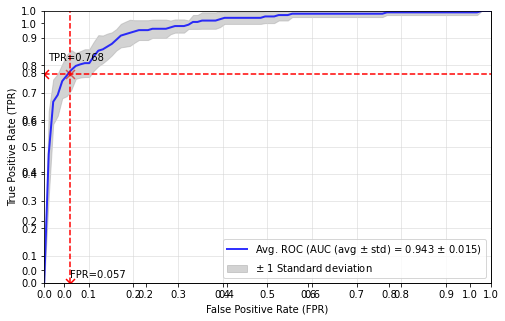


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.943 +/- 0.015
Accuracy (Avg. +/- Std.) is  0.888 +/- 0.025
Avg. CM is [[30, 5], [9, 82]]
Total for all folds CM is [[152, 25], [46, 413]]


In [21]:
Accuracy = []                                                                
FP = []                                                                      
TN = []                                                                      
FN = []                                                                      
TP = []                                                                      
tprs = []                                                                  
aucs_aBoost = []                                                             
iterator=0

mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))


for train_index, test_index in kf.split(X_Data,Y_Lavel):                    
   
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]                
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index] 


  
    
    tuned_parameters = {"learning_rate": [0.01, 0.05, 0.1],
              "n_estimators": [200, 500, 1000],
              "max_depth":[5,8,10],
              "colsample_bytree": [1,0.5,0.3]}
    
    clf = creat_Model (classifier = LGBMClassifier(random_state=42),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    
    
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),            
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_aBoost.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                              
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
average_ROC(mean_fpr,tprs,aucs_aBoost,TP,TN,FP,FN)                          
average_performance(aucs_aBoost,Accuracy,TP,TN,FP,FN)                        
    
    

### Logistic Regression

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.87      0.97      0.91        88
           1       0.90      0.68      0.77        40

    accuracy                           0.88       128
   macro avg       0.88      0.82      0.84       128
weighted avg       0.88      0.88      0.87       128


Area Under ROC (AUC): 0.9088068181818181

Confusion Matrix for current fold: 
[[85  3]
 [13 27]]

Accuracy for Current Fold: 0.875

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.79      0.89      0.84        87
           1       0.67      0.50      0.57        40

    accuracy                           0.76       127
   macro avg       0.73      0.69      0.70       127
weighted avg       0.75      0.76      0.75       127


Area Under

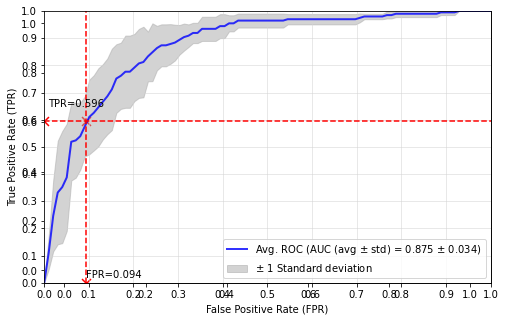


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.875 +/- 0.034
Accuracy (Avg. +/- Std.) is  0.810 +/- 0.045
Avg. CM is [[23, 8], [16, 79]]
Total for all folds CM is [[118, 41], [80, 397]]


In [32]:
Accuracy = []                                                                
FP = []                                                                      
TN = []                                                                      
FN = []                                                                      
TP = []                                                                      
tprs = []                                                                  
aucs_aBoost = []                                                             
iterator=0

mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))


for train_index, test_index in kf.split(X_Data,Y_Lavel):                    
   
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]                
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index] 


    tuned_parameters = { 'penalty': ['l1','l2']}
    clf = creat_Model (classifier = LogisticRegression(random_state = 42),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    
    
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),            
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_aBoost.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                              
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
average_ROC(mean_fpr,tprs,aucs_aBoost,TP,TN,FP,FN)                          
average_performance(aucs_aBoost,Accuracy,TP,TN,FP,FN)                        
    
    
    

### SVM

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.87      0.92      0.90        88
           1       0.80      0.70      0.75        40

    accuracy                           0.85       128
   macro avg       0.84      0.81      0.82       128
weighted avg       0.85      0.85      0.85       128


Area Under ROC (AUC): 0.8911931818181819

Confusion Matrix for current fold: 
[[81  7]
 [12 28]]

Accuracy for Current Fold: 0.8515625

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.88      0.87      0.88        87
           1       0.73      0.75      0.74        40

    accuracy                           0.83       127
   macro avg       0.81      0.81      0.81       127
weighted avg       0.84      0.83      0.84       127


Area U

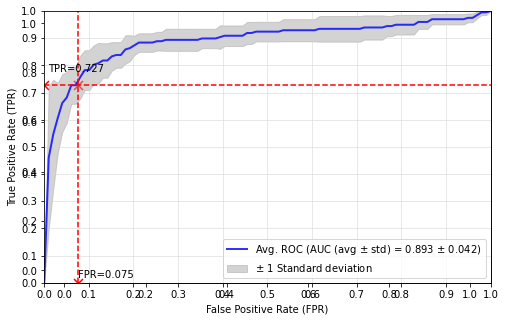


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.893 +/- 0.042
Accuracy (Avg. +/- Std.) is  0.863 +/- 0.031
Avg. CM is [[28, 6], [10, 81]]
Total for all folds CM is [[144, 33], [54, 405]]


In [41]:
Accuracy = []                                                                
FP = []                                                                      
TN = []                                                                      
FN = []                                                                      
TP = []                                                                      
tprs = []                                                                  
aucs_aBoost = []                                                             
iterator=0

mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))



for train_index, test_index in kf.split(X_Data,Y_Lavel):                    
   
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]                
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index] 


    tuned_parameters = {'kernel':['linear', 'rbf'],
                        'C':[1,2.5,3]}
    
    clf_svm = creat_Model (classifier = SVC(random_state = 42,gamma = 0.001, probability=True),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    
    
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),            
                                                y_pred = clf_svm.predict(X_Test),
                                                probas_ = clf_svm.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_aBoost.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                              
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf_svm.predict(X_Test)))
average_ROC(mean_fpr,tprs,aucs_aBoost,TP,TN,FP,FN)                          
average_performance(aucs_aBoost,Accuracy,TP,TN,FP,FN)    

### Gradient Boosting Classifier

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        88
           1       0.83      0.75      0.79        40

    accuracy                           0.88       128
   macro avg       0.86      0.84      0.85       128
weighted avg       0.87      0.88      0.87       128


Area Under ROC (AUC): 0.934375

Confusion Matrix for current fold: 
[[82  6]
 [10 30]]

Accuracy for Current Fold: 0.875

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        87
           1       0.76      0.72      0.74        40

    accuracy                           0.84       127
   macro avg       0.82      0.81      0.81       127
weighted avg       0.84      0.84      0.84       127


Area Under ROC (AUC)

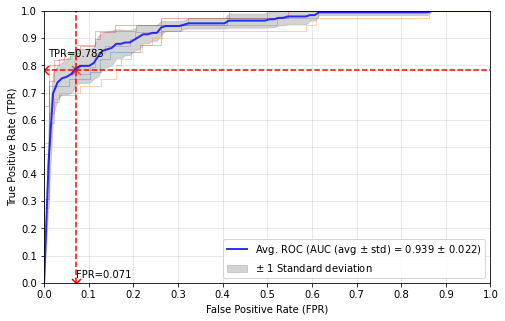


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.939 +/- 0.022
Accuracy (Avg. +/- Std.) is  0.884 +/- 0.026
Avg. CM is [[31, 6], [8, 81]]
Total for all folds CM is [[155, 31], [43, 407]]


In [ ]:
Accuracy = []                                                                
FP = []                                                                      
TN = []                                                                      
FN = []                                                                      
TP = []                                                                      
tprs = []                                                                  
aucs_aBoost = []                                                             
iterator=0

mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))


for train_index, test_index in kf.split(X_Data,Y_Lavel):                    
   
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]                
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index] 


    tuned_parameters = { 'loss': ['deviance','exponential'],
                        "learning_rate": [0.01, 0.05, 0.1],
                        "n_estimators": [200, 500, 1000],
                        "max_depth":[5,8,10]}
    clf = creat_Model (classifier = GradientBoostingClassifier(random_state = 42),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    
    
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),            
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_aBoost.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                              
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
average_ROC(mean_fpr,tprs,aucs_aBoost,TP,TN,FP,FN)                          
average_performance(aucs_aBoost,Accuracy,TP,TN,FP,FN)                        
    

### LDA

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.87      0.98      0.92        88
           1       0.93      0.68      0.78        40

    accuracy                           0.88       128
   macro avg       0.90      0.83      0.85       128
weighted avg       0.89      0.88      0.88       128


Area Under ROC (AUC): 0.9090909090909091

Confusion Matrix for current fold: 
[[86  2]
 [13 27]]

Accuracy for Current Fold: 0.8828125

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.80      0.90      0.84        87
           1       0.69      0.50      0.58        40

    accuracy                           0.77       127
   macro avg       0.74      0.70      0.71       127
weighted avg       0.76      0.77      0.76       127


Area U

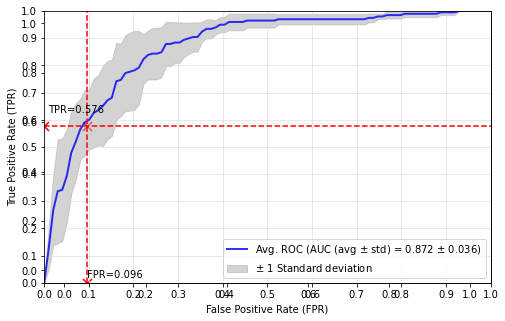


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.872 +/- 0.036
Accuracy (Avg. +/- Std.) is  0.802 +/- 0.051
Avg. CM is [[22, 8], [16, 79]]
Total for all folds CM is [[114, 42], [84, 396]]


In [14]:
Accuracy = []                                                                
FP = []                                                                      
TN = []                                                                      
FN = []                                                                      
TP = []                                                                      
tprs = []                                                                  
aucs_aBoost = []                                                             
iterator=0

mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))


for train_index, test_index in kf.split(X_Data,Y_Lavel):                    
   
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]                
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index] 


    tuned_parameters = {'solver':['svd','lsqr','eigen']}
    
    clf = creat_Model (classifier = LinearDiscriminantAnalysis(),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    
    
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),            
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_aBoost.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                              
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
average_ROC(mean_fpr,tprs,aucs_aBoost,TP,TN,FP,FN)                          
average_performance(aucs_aBoost,Accuracy,TP,TN,FP,FN)                        
    

### CatBoost

In [ ]:
Accuracy = []                                                                
FP = []                                                                      
TN = []                                                                      
FN = []                                                                      
TP = []                                                                      
tprs = []                                                                  
aucs_aBoost = []                                                             
iterator=0

mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))


for train_index, test_index in kf.split(X_Data,Y_Lavel):                    
   
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]                
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index] 


    tuned_parameters = {}
    
    clf = creat_Model (classifier = CatBoostClassifier(max_depth = 3, n_estimators = 300),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    
    
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),            
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_aBoost.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                              
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
average_ROC(mean_fpr,tprs,aucs_aBoost,TP,TN,FP,FN)                          
average_performance(aucs_aBoost,Accuracy,TP,TN,FP,FN)             

In [25]:
def Ensembler(n_model, X_Train, Y_Train, X_Test, Y_Test, weight):
   
    # logistic regression
    tuned_parameters_lr = { 'penalty': ['l1','l2']}
    clf_lr = creat_Model (classifier = LogisticRegression(random_state = 42),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters_lr,
                      verbose=0)
    
    
    
    
    
    # svm
    tuned_parameters_svm = {'kernel':['linear', 'rbf'],
                        'C':[3,10]}
    
    clf_svm = creat_Model (classifier = SVC(random_state = 42,gamma = 0.001, probability=True),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters_svm,
                      verbose=0)
    
    
    # lgbm
    tuned_parameters = {"learning_rate": [0.01, 0.05, 0.1],
              "n_estimators": [200, 500, 1000],
              "max_depth":[5,8,10],
              "colsample_bytree": [1,0.5,0.3]}
    
    clf_lgbm = creat_Model (classifier = LGBMClassifier(random_state=42),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    
    # Gradient Boosting Classifier
    tuned_parameters = { 'loss': ['deviance','exponential'],
                        "learning_rate": [0.01, 0.05, 0.1],
                        "n_estimators": [200, 500, 1000],
                        "max_depth":[5,8,10]}
    clf_gbc = creat_Model (classifier = GradientBoostingClassifier(random_state = 42),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    
    # LDA
    tuned_parameters = {'solver':['svd','lsqr','eigen']}
    clf_lda = creat_Model (classifier = LinearDiscriminantAnalysis(),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)    
        
    
    
    # catboost
    
    
    clf_cb = creat_Model (classifier = CatBoostClassifier(max_depth = 3, n_estimators = 300),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = {},
                      verbose=0)
                                                                     
    n_neighbors = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49]
    leaf_size = [5,10,15,20,25,30,35,40,45,50]
    Distance = [1,2]
                                                                      
    tuned_parameters_knn = [ {'n_neighbors': n_neighbors, 
                        'algorithm' : ['brute'],
                        'p':Distance},
                         
                         {'n_neighbors': n_neighbors, 
                        'algorithm' : ['ball_tree'],
                        'leaf_size' : leaf_size,
                        'p':Distance},
                          
                        {'n_neighbors': n_neighbors, 
                        'algorithm' : ['kd_tree'],
                        'leaf_size' : leaf_size,
                        'p':Distance}]
    
    
  

    clf_knn = creat_Model (classifier = KNeighborsClassifier(),               
                      X_Train = X_Train,
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters_knn,
                      verbose=0)
    
    tuned_parameters_ab = { 'algorithm': ['SAMME','SAMME.R'],         
                   'learning_rate':[0.1,0.5,1.0],
                   'n_estimators': [10,50,100,200]}

    clf_ab = creat_Model (classifier = AdaBoostClassifier(random_state=random_initializer),
                  X_Train = X_Train,                                
                  Y_Train = Y_Train,
                  tuned_parameters = tuned_parameters_ab,
                  verbose=0)
    
    tuned_parameters_dt = {'criterion': ['gini','entropy'],         
                       'splitter': ['best'],
                       'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                       'min_samples_leaf': [1,2,3,4,5] }

    clf_dt = creat_Model (classifier = DecisionTreeClassifier(random_state=random_initializer),
                      X_Train = X_Train,                            
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters_dt,
                      verbose=0)
    
    tuned_parameters_rf = {'criterion': ['gini','entropy']}         

    clf_rf = creat_Model (classifier = RandomForestClassifier(random_state=random_initializer),
                      X_Train = X_Train,                             
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters_rf,
                      verbose=0)
    
    var_smoothing = [1e-01,
                    1e-02,
                    1e-03,
                    1e-04,
                    1e-05,
                    1e-06,
                    1e-07,
                    1e-08,
                    1e-09,
                    1e-10,
                    1e-11,
                    1e-12]

    tuned_parameters_nb = [{'var_smoothing': var_smoothing}]         

    clf_nb = creat_Model (classifier = GaussianNB(),               
                      X_Train = X_Train,
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters_nb,
                      verbose=0)
    tuned_parameters_xb = {                                          
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

        
    clf_xb = creat_Model (classifier = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'error',random_state=random_initializer,
                                                use_label_encoder=False ),
                      X_Train = X_Train,                             
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters_xb,
                      verbose=0)
    
    
    if weight == 'None':                                             
        if n_model == 2:                                              
            model = VotingClassifier([('ab', clf_ab), 
                                      ('xb', clf_xb)], 
                                     voting='soft')
            model.fit(X_Train,Y_Train)
            return model 
        if n_model == 3:                                                                            
            model = VotingClassifier([('knn', clf_knn), 
                                      ('xb', clf_xb),
                                      ('dt',clf_dt)], 
                                     voting='soft')
            model.fit(X_Train,Y_Train)
            return model
        if n_model == 4:                                              
            model = VotingClassifier([('ab', clf_ab), 
                                      ('xb', clf_xb),
                                      ('dt',clf_dt),
                                      ('rf',clf_rf)], 
                                     voting='soft')
            model.fit(X_Train,Y_Train)
            return model
        if n_model == 5:                                                   
            model = VotingClassifier([('knn', clf_knn), 
                                      ('xb', clf_xb),
                                      ('dt',clf_dt),
                                      ('rf',clf_rf),
                                      ('nb',clf_nb)], 
                                     voting='soft')
            model.fit(X_Train,Y_Train)
            return model
        
        if n_model == 6:                                               
            model = VotingClassifier([ ('xb', clf_xb),
                                      ('cb',clf_cb)], 
                                     voting='soft')
            model.fit(X_Train,Y_Train)
            return model
        
        
        if n_model == 7:                                                 
            model = VotingClassifier([('knn', clf_knn), 
                                      ('xb', clf_xb),
                                      ('dt',clf_dt),
                                      ('rf',clf_rf),
                                      ('nb',clf_nb),
                                      ('ab',clf_ab),
                                      ('svc',clf_svm)],
                                     voting='soft',
                                     weights=[accuracy_score(Y_Test, clf_knn.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_xb.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_dt.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_rf.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_nb.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_ab.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_svm.predict(X_Test))])
            model.fit(X_Train,Y_Train)
            return model
        
        
        if n_model == 8:                                              
            model = VotingClassifier([('knn', clf_knn), 
                                      ('xb', clf_xb),
                                      ('dt',clf_dt),
                                      ('rf',clf_rf),
                                      ('nb',clf_nb),
                                      ('ab',clf_ab),
                                      ('svc',clf_svm),
                                      ('lr',clf_lr)
                                     ], 
                                     voting='soft',
                                     weights=[accuracy_score(Y_Test, clf_knn.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_xb.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_dt.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_rf.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_nb.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_ab.predict(X_Test)),
                                             accuracy_score(Y_Test, clf_svm.predict(X_Test)),
                                             accuracy_score(Y_Test, clf_lr.predict(X_Test))])
            model.fit(X_Train,Y_Train)
            return model
        
        if n_model == 9:
            model = VotingClassifier([('xb', clf_xb),
                                      ('ab',clf_ab),
                                      ('lgbm',clf_lgbm)], 
                                     voting='soft',
                                     weights=[accuracy_score(Y_Test, clf_xb.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_ab.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_lgbm.predict(X_Test))])
            model.fit(X_Train,Y_Train)
            return model
        
        if n_model == 10:
            model = VotingClassifier([('xb', clf_xb),
                                      ('lgbm',clf_lgbm)], 
                                     voting='soft',
                                     weights=[accuracy_score(Y_Test, clf_xb.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_lgbm.predict(X_Test))])
            model.fit(X_Train,Y_Train)
            return model
        
        if n_model == 11:
            model = VotingClassifier([('xb', clf_xb),
                                      ('lgbm',clf_lgbm),
                                       ('rf',clf_rf)],
                                     voting='soft',
                                     weights=[accuracy_score(Y_Test, clf_xb.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_lgbm.predict(X_Test)),
                                             accuracy_score(Y_Test, clf_rf.predict(X_Test))])
            model.fit(X_Train,Y_Train)
            return model

        if n_model == 12:
            model = VotingClassifier([('xb', clf_xb),
                                      ('lgbm',clf_lgbm),
                                       ('gbc',clf_gbc)],
                                     voting='soft',
                                     weights=[accuracy_score(Y_Test, clf_xb.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_lgbm.predict(X_Test)),
                                             accuracy_score(Y_Test, clf_gbc.predict(X_Test))])
            model.fit(X_Train,Y_Train)
            return model

        if n_model == 13:
            model = VotingClassifier([('xb', clf_xb),
                                      ('lgbm',clf_lgbm),
                                       ('lda',clf_lda)],
                                     voting='soft',
                                     weights=[accuracy_score(Y_Test, clf_xb.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_lgbm.predict(X_Test)),
                                             accuracy_score(Y_Test, clf_lda.predict(X_Test))])
            model.fit(X_Train,Y_Train)
            return model
        
        if n_model == 14:
            model = VotingClassifier([('xb', clf_xb),
                                      ('lgbm',clf_lgbm),
                                       ('lda',clf_lda)],
                                     voting='soft',
                                     weights=[accuracy_score(Y_Test, clf_xb.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_lgbm.predict(X_Test)),
                                             accuracy_score(Y_Test, clf_lda.predict(X_Test))])
            model.fit(X_Train,Y_Train)
            return model
        
        
    


       
        
   


### Analyzing  XB + CB

Learning rate set to 0.023271
0:	learn: 0.6748632	total: 814us	remaining: 244ms
1:	learn: 0.6551513	total: 1.73ms	remaining: 258ms
2:	learn: 0.6398643	total: 2.84ms	remaining: 282ms
3:	learn: 0.6276869	total: 3.79ms	remaining: 281ms
4:	learn: 0.6113621	total: 4.67ms	remaining: 276ms
5:	learn: 0.5967644	total: 5.49ms	remaining: 269ms
6:	learn: 0.5807832	total: 6.41ms	remaining: 268ms
7:	learn: 0.5683814	total: 7.28ms	remaining: 266ms
8:	learn: 0.5563732	total: 8.17ms	remaining: 264ms
9:	learn: 0.5432302	total: 9.03ms	remaining: 262ms
10:	learn: 0.5329972	total: 9.87ms	remaining: 259ms
11:	learn: 0.5210643	total: 11ms	remaining: 264ms
12:	learn: 0.5089439	total: 11.9ms	remaining: 264ms
13:	learn: 0.5007330	total: 13.1ms	remaining: 268ms
14:	learn: 0.4904060	total: 14.5ms	remaining: 276ms
15:	learn: 0.4794084	total: 15.5ms	remaining: 275ms
16:	learn: 0.4692694	total: 16.4ms	remaining: 274ms
17:	learn: 0.4599191	total: 17.4ms	remaining: 272ms
18:	learn: 0.4528756	total: 18.4ms	remaining: 2

171:	learn: 0.2213755	total: 166ms	remaining: 123ms
172:	learn: 0.2212499	total: 167ms	remaining: 123ms
173:	learn: 0.2209712	total: 168ms	remaining: 122ms
174:	learn: 0.2208569	total: 170ms	remaining: 121ms
175:	learn: 0.2204630	total: 171ms	remaining: 121ms
176:	learn: 0.2202728	total: 173ms	remaining: 120ms
177:	learn: 0.2198522	total: 174ms	remaining: 119ms
178:	learn: 0.2195536	total: 175ms	remaining: 118ms
179:	learn: 0.2189813	total: 176ms	remaining: 118ms
180:	learn: 0.2185844	total: 177ms	remaining: 117ms
181:	learn: 0.2182520	total: 179ms	remaining: 116ms
182:	learn: 0.2179954	total: 180ms	remaining: 115ms
183:	learn: 0.2178116	total: 181ms	remaining: 114ms
184:	learn: 0.2172259	total: 182ms	remaining: 113ms
185:	learn: 0.2168236	total: 183ms	remaining: 112ms
186:	learn: 0.2166588	total: 184ms	remaining: 111ms
187:	learn: 0.2152923	total: 185ms	remaining: 110ms
188:	learn: 0.2152000	total: 186ms	remaining: 109ms
189:	learn: 0.2150765	total: 187ms	remaining: 108ms
190:	learn: 

177:	learn: 0.2198522	total: 168ms	remaining: 115ms
178:	learn: 0.2195536	total: 169ms	remaining: 114ms
179:	learn: 0.2189813	total: 171ms	remaining: 114ms
180:	learn: 0.2185844	total: 172ms	remaining: 113ms
181:	learn: 0.2182520	total: 172ms	remaining: 112ms
182:	learn: 0.2179954	total: 173ms	remaining: 111ms
183:	learn: 0.2178116	total: 174ms	remaining: 110ms
184:	learn: 0.2172259	total: 176ms	remaining: 109ms
185:	learn: 0.2168236	total: 177ms	remaining: 108ms
186:	learn: 0.2166588	total: 178ms	remaining: 107ms
187:	learn: 0.2152923	total: 179ms	remaining: 106ms
188:	learn: 0.2152000	total: 180ms	remaining: 105ms
189:	learn: 0.2150765	total: 181ms	remaining: 105ms
190:	learn: 0.2146569	total: 182ms	remaining: 104ms
191:	learn: 0.2144199	total: 182ms	remaining: 103ms
192:	learn: 0.2143164	total: 183ms	remaining: 102ms
193:	learn: 0.2141791	total: 184ms	remaining: 101ms
194:	learn: 0.2137679	total: 185ms	remaining: 99.8ms
195:	learn: 0.2134794	total: 186ms	remaining: 98.8ms
196:	learn

182:	learn: 0.2114187	total: 170ms	remaining: 108ms
183:	learn: 0.2110118	total: 171ms	remaining: 108ms
184:	learn: 0.2105997	total: 172ms	remaining: 107ms
185:	learn: 0.2101841	total: 173ms	remaining: 106ms
186:	learn: 0.2099455	total: 174ms	remaining: 105ms
187:	learn: 0.2094329	total: 175ms	remaining: 104ms
188:	learn: 0.2091346	total: 176ms	remaining: 103ms
189:	learn: 0.2087283	total: 177ms	remaining: 102ms
190:	learn: 0.2081906	total: 178ms	remaining: 102ms
191:	learn: 0.2074454	total: 179ms	remaining: 101ms
192:	learn: 0.2071715	total: 180ms	remaining: 99.7ms
193:	learn: 0.2068215	total: 181ms	remaining: 98.8ms
194:	learn: 0.2063733	total: 182ms	remaining: 97.8ms
195:	learn: 0.2062544	total: 183ms	remaining: 96.9ms
196:	learn: 0.2058778	total: 184ms	remaining: 96ms
197:	learn: 0.2054746	total: 185ms	remaining: 95.1ms
198:	learn: 0.2049615	total: 186ms	remaining: 94.2ms
199:	learn: 0.2046578	total: 187ms	remaining: 93.3ms
200:	learn: 0.2043113	total: 187ms	remaining: 92.3ms
201:	

238:	learn: 0.1828808	total: 250ms	remaining: 63.9ms
239:	learn: 0.1827851	total: 251ms	remaining: 62.9ms
240:	learn: 0.1822865	total: 253ms	remaining: 61.8ms
241:	learn: 0.1820698	total: 254ms	remaining: 60.8ms
242:	learn: 0.1818827	total: 255ms	remaining: 59.7ms
243:	learn: 0.1815629	total: 256ms	remaining: 58.7ms
244:	learn: 0.1809269	total: 257ms	remaining: 57.6ms
245:	learn: 0.1807679	total: 258ms	remaining: 56.6ms
246:	learn: 0.1805400	total: 259ms	remaining: 55.5ms
247:	learn: 0.1799124	total: 260ms	remaining: 54.5ms
248:	learn: 0.1797228	total: 261ms	remaining: 53.4ms
249:	learn: 0.1796051	total: 262ms	remaining: 52.4ms
250:	learn: 0.1793589	total: 263ms	remaining: 51.3ms
251:	learn: 0.1789128	total: 264ms	remaining: 50.3ms
252:	learn: 0.1788090	total: 265ms	remaining: 49.2ms
253:	learn: 0.1785678	total: 266ms	remaining: 48.2ms
254:	learn: 0.1783072	total: 267ms	remaining: 47.1ms
255:	learn: 0.1780431	total: 268ms	remaining: 46.1ms
256:	learn: 0.1776880	total: 269ms	remaining: 

Learning rate set to 0.021147
0:	learn: 0.6751079	total: 67.2ms	remaining: 20.1s
1:	learn: 0.6596144	total: 68.3ms	remaining: 10.2s
2:	learn: 0.6414566	total: 69.3ms	remaining: 6.86s
3:	learn: 0.6279081	total: 70.3ms	remaining: 5.21s
4:	learn: 0.6143923	total: 71.4ms	remaining: 4.21s
5:	learn: 0.6016860	total: 72.5ms	remaining: 3.55s
6:	learn: 0.5872844	total: 73.5ms	remaining: 3.08s
7:	learn: 0.5731005	total: 75.1ms	remaining: 2.74s
8:	learn: 0.5593759	total: 76.2ms	remaining: 2.46s
9:	learn: 0.5479969	total: 77.3ms	remaining: 2.24s
10:	learn: 0.5374229	total: 78.3ms	remaining: 2.06s
11:	learn: 0.5256425	total: 79.4ms	remaining: 1.91s
12:	learn: 0.5162495	total: 80.4ms	remaining: 1.77s
13:	learn: 0.5077416	total: 81.5ms	remaining: 1.66s
14:	learn: 0.4994913	total: 82.5ms	remaining: 1.57s
15:	learn: 0.4934996	total: 83.6ms	remaining: 1.48s
16:	learn: 0.4836147	total: 84.8ms	remaining: 1.41s
17:	learn: 0.4763837	total: 85.8ms	remaining: 1.34s
18:	learn: 0.4683769	total: 86.9ms	remaining

Learning rate set to 0.023291
0:	learn: 0.6701942	total: 1.07ms	remaining: 321ms
1:	learn: 0.6531396	total: 2.29ms	remaining: 341ms
2:	learn: 0.6384410	total: 3.87ms	remaining: 383ms
3:	learn: 0.6252839	total: 5.03ms	remaining: 372ms
4:	learn: 0.6080445	total: 6.08ms	remaining: 359ms
5:	learn: 0.5944230	total: 7.39ms	remaining: 362ms
6:	learn: 0.5777324	total: 8.33ms	remaining: 349ms
7:	learn: 0.5641348	total: 9.3ms	remaining: 339ms
8:	learn: 0.5506582	total: 10.3ms	remaining: 332ms
9:	learn: 0.5370220	total: 11.2ms	remaining: 326ms
10:	learn: 0.5233519	total: 12.2ms	remaining: 319ms
11:	learn: 0.5142197	total: 13.1ms	remaining: 315ms
12:	learn: 0.5035396	total: 14.1ms	remaining: 311ms
13:	learn: 0.4929398	total: 15.1ms	remaining: 308ms
14:	learn: 0.4821029	total: 16.1ms	remaining: 305ms
15:	learn: 0.4719748	total: 17.1ms	remaining: 303ms
16:	learn: 0.4621851	total: 18ms	remaining: 299ms
17:	learn: 0.4531482	total: 18.9ms	remaining: 295ms
18:	learn: 0.4456049	total: 20.3ms	remaining: 3

174:	learn: 0.2142260	total: 167ms	remaining: 119ms
175:	learn: 0.2139275	total: 169ms	remaining: 119ms
176:	learn: 0.2137625	total: 170ms	remaining: 118ms
177:	learn: 0.2133262	total: 171ms	remaining: 117ms
178:	learn: 0.2128703	total: 172ms	remaining: 116ms
179:	learn: 0.2124305	total: 173ms	remaining: 115ms
180:	learn: 0.2120494	total: 174ms	remaining: 114ms
181:	learn: 0.2117596	total: 175ms	remaining: 114ms
182:	learn: 0.2114187	total: 176ms	remaining: 113ms
183:	learn: 0.2110118	total: 177ms	remaining: 112ms
184:	learn: 0.2105997	total: 178ms	remaining: 111ms
185:	learn: 0.2101841	total: 179ms	remaining: 110ms
186:	learn: 0.2099455	total: 180ms	remaining: 109ms
187:	learn: 0.2094329	total: 181ms	remaining: 108ms
188:	learn: 0.2091346	total: 182ms	remaining: 107ms
189:	learn: 0.2087283	total: 183ms	remaining: 106ms
190:	learn: 0.2081906	total: 184ms	remaining: 105ms
191:	learn: 0.2074454	total: 185ms	remaining: 104ms
192:	learn: 0.2071715	total: 186ms	remaining: 103ms
193:	learn: 

178:	learn: 0.2335370	total: 170ms	remaining: 115ms
179:	learn: 0.2332538	total: 172ms	remaining: 114ms
180:	learn: 0.2329015	total: 172ms	remaining: 113ms
181:	learn: 0.2327157	total: 173ms	remaining: 112ms
182:	learn: 0.2323928	total: 175ms	remaining: 112ms
183:	learn: 0.2320334	total: 176ms	remaining: 111ms
184:	learn: 0.2318835	total: 177ms	remaining: 110ms
185:	learn: 0.2317124	total: 177ms	remaining: 109ms
186:	learn: 0.2312414	total: 179ms	remaining: 108ms
187:	learn: 0.2311262	total: 179ms	remaining: 107ms
188:	learn: 0.2309527	total: 180ms	remaining: 106ms
189:	learn: 0.2305008	total: 181ms	remaining: 105ms
190:	learn: 0.2302541	total: 182ms	remaining: 104ms
191:	learn: 0.2301785	total: 183ms	remaining: 103ms
192:	learn: 0.2300630	total: 184ms	remaining: 102ms
193:	learn: 0.2294746	total: 185ms	remaining: 101ms
194:	learn: 0.2290793	total: 186ms	remaining: 100ms
195:	learn: 0.2286805	total: 187ms	remaining: 99.3ms
196:	learn: 0.2280871	total: 188ms	remaining: 98.3ms
197:	learn

202:	learn: 0.2122119	total: 148ms	remaining: 70.9ms
203:	learn: 0.2119471	total: 149ms	remaining: 70.1ms
204:	learn: 0.2115401	total: 150ms	remaining: 69.3ms
205:	learn: 0.2110519	total: 151ms	remaining: 68.7ms
206:	learn: 0.2107477	total: 151ms	remaining: 68ms
207:	learn: 0.2102459	total: 152ms	remaining: 67.3ms
208:	learn: 0.2099409	total: 153ms	remaining: 66.5ms
209:	learn: 0.2096057	total: 153ms	remaining: 65.7ms
210:	learn: 0.2094965	total: 154ms	remaining: 64.9ms
211:	learn: 0.2092492	total: 155ms	remaining: 64.1ms
212:	learn: 0.2085174	total: 155ms	remaining: 63.4ms
213:	learn: 0.2081280	total: 156ms	remaining: 62.6ms
214:	learn: 0.2077334	total: 156ms	remaining: 61.8ms
215:	learn: 0.2071524	total: 157ms	remaining: 61.1ms
216:	learn: 0.2067838	total: 158ms	remaining: 60.3ms
217:	learn: 0.2062485	total: 158ms	remaining: 59.5ms
218:	learn: 0.2059664	total: 159ms	remaining: 58.7ms
219:	learn: 0.2054425	total: 160ms	remaining: 58ms
220:	learn: 0.2050783	total: 160ms	remaining: 57.3

129:	learn: 0.2549839	total: 125ms	remaining: 164ms
130:	learn: 0.2546631	total: 126ms	remaining: 163ms
131:	learn: 0.2541476	total: 127ms	remaining: 162ms
132:	learn: 0.2530938	total: 128ms	remaining: 161ms
133:	learn: 0.2524983	total: 129ms	remaining: 160ms
134:	learn: 0.2519666	total: 130ms	remaining: 159ms
135:	learn: 0.2510409	total: 131ms	remaining: 158ms
136:	learn: 0.2502436	total: 132ms	remaining: 157ms
137:	learn: 0.2493514	total: 133ms	remaining: 156ms
138:	learn: 0.2491003	total: 134ms	remaining: 155ms
139:	learn: 0.2485265	total: 135ms	remaining: 154ms
140:	learn: 0.2482787	total: 136ms	remaining: 154ms
141:	learn: 0.2476314	total: 137ms	remaining: 153ms
142:	learn: 0.2471120	total: 138ms	remaining: 152ms
143:	learn: 0.2468158	total: 139ms	remaining: 151ms
144:	learn: 0.2462872	total: 140ms	remaining: 150ms
145:	learn: 0.2460540	total: 141ms	remaining: 149ms
146:	learn: 0.2454229	total: 142ms	remaining: 148ms
147:	learn: 0.2450485	total: 143ms	remaining: 147ms
148:	learn: 

287:	learn: 0.1952652	total: 290ms	remaining: 12.1ms
288:	learn: 0.1949064	total: 292ms	remaining: 11.1ms
289:	learn: 0.1945718	total: 293ms	remaining: 10.1ms
290:	learn: 0.1941803	total: 294ms	remaining: 9.09ms
291:	learn: 0.1933585	total: 297ms	remaining: 8.15ms
292:	learn: 0.1932455	total: 299ms	remaining: 7.13ms
293:	learn: 0.1930672	total: 300ms	remaining: 6.12ms
294:	learn: 0.1927699	total: 301ms	remaining: 5.1ms
295:	learn: 0.1925397	total: 302ms	remaining: 4.08ms
296:	learn: 0.1923500	total: 308ms	remaining: 3.11ms
297:	learn: 0.1920851	total: 309ms	remaining: 2.07ms
298:	learn: 0.1917048	total: 310ms	remaining: 1.04ms
299:	learn: 0.1914722	total: 311ms	remaining: 0us
--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.92      0.95      0.94        87
           1       0.89      0.82      0.86        40

    accuracy                           0.91       

Learning rate set to 0.023291
0:	learn: 0.6761381	total: 1.14ms	remaining: 341ms
1:	learn: 0.6578711	total: 2.13ms	remaining: 318ms
2:	learn: 0.6394432	total: 3.11ms	remaining: 308ms
3:	learn: 0.6236808	total: 4.02ms	remaining: 297ms
4:	learn: 0.6074449	total: 4.95ms	remaining: 292ms
5:	learn: 0.5931475	total: 5.86ms	remaining: 287ms
6:	learn: 0.5794166	total: 6.86ms	remaining: 287ms
7:	learn: 0.5658128	total: 7.83ms	remaining: 286ms
8:	learn: 0.5516846	total: 8.79ms	remaining: 284ms
9:	learn: 0.5388931	total: 9.68ms	remaining: 281ms
10:	learn: 0.5286948	total: 10.7ms	remaining: 280ms
11:	learn: 0.5167955	total: 11.5ms	remaining: 277ms
12:	learn: 0.5061401	total: 12.5ms	remaining: 275ms
13:	learn: 0.4955251	total: 13.4ms	remaining: 274ms
14:	learn: 0.4861904	total: 14.3ms	remaining: 272ms
15:	learn: 0.4763111	total: 15.2ms	remaining: 270ms
16:	learn: 0.4689538	total: 16.2ms	remaining: 269ms
17:	learn: 0.4607398	total: 17ms	remaining: 267ms
18:	learn: 0.4539425	total: 17.9ms	remaining: 

184:	learn: 0.2231623	total: 169ms	remaining: 105ms
185:	learn: 0.2229412	total: 170ms	remaining: 104ms
186:	learn: 0.2226792	total: 171ms	remaining: 103ms
187:	learn: 0.2223116	total: 172ms	remaining: 102ms
188:	learn: 0.2219249	total: 173ms	remaining: 102ms
189:	learn: 0.2216549	total: 174ms	remaining: 101ms
190:	learn: 0.2211526	total: 175ms	remaining: 99.8ms
191:	learn: 0.2210459	total: 176ms	remaining: 98.9ms
192:	learn: 0.2202545	total: 177ms	remaining: 98ms
193:	learn: 0.2201304	total: 178ms	remaining: 97.1ms
194:	learn: 0.2199468	total: 179ms	remaining: 96.2ms
195:	learn: 0.2195303	total: 180ms	remaining: 95.3ms
196:	learn: 0.2192430	total: 181ms	remaining: 94.4ms
197:	learn: 0.2187532	total: 182ms	remaining: 93.5ms
198:	learn: 0.2186265	total: 183ms	remaining: 92.6ms
199:	learn: 0.2183448	total: 183ms	remaining: 91.7ms
200:	learn: 0.2179362	total: 184ms	remaining: 90.8ms
201:	learn: 0.2177797	total: 185ms	remaining: 89.9ms
202:	learn: 0.2175781	total: 186ms	remaining: 89ms
203

171:	learn: 0.2268497	total: 168ms	remaining: 125ms
172:	learn: 0.2264784	total: 170ms	remaining: 125ms
173:	learn: 0.2261938	total: 171ms	remaining: 124ms
174:	learn: 0.2258915	total: 172ms	remaining: 123ms
175:	learn: 0.2256111	total: 173ms	remaining: 122ms
176:	learn: 0.2253972	total: 174ms	remaining: 121ms
177:	learn: 0.2253032	total: 175ms	remaining: 120ms
178:	learn: 0.2251508	total: 176ms	remaining: 119ms
179:	learn: 0.2250172	total: 177ms	remaining: 118ms
180:	learn: 0.2247211	total: 178ms	remaining: 117ms
181:	learn: 0.2243597	total: 180ms	remaining: 117ms
182:	learn: 0.2241244	total: 181ms	remaining: 116ms
183:	learn: 0.2238405	total: 181ms	remaining: 114ms
184:	learn: 0.2231623	total: 182ms	remaining: 113ms
185:	learn: 0.2229412	total: 183ms	remaining: 112ms
186:	learn: 0.2226792	total: 184ms	remaining: 111ms
187:	learn: 0.2223116	total: 185ms	remaining: 110ms
188:	learn: 0.2219249	total: 186ms	remaining: 109ms
189:	learn: 0.2216549	total: 187ms	remaining: 108ms
190:	learn: 

Learning rate set to 0.023291
0:	learn: 0.6745943	total: 956us	remaining: 286ms
1:	learn: 0.6570968	total: 1.9ms	remaining: 282ms
2:	learn: 0.6420126	total: 2.88ms	remaining: 286ms
3:	learn: 0.6285919	total: 3.79ms	remaining: 281ms
4:	learn: 0.6119115	total: 4.75ms	remaining: 280ms
5:	learn: 0.5957172	total: 5.68ms	remaining: 278ms
6:	learn: 0.5796175	total: 6.64ms	remaining: 278ms
7:	learn: 0.5654587	total: 7.63ms	remaining: 278ms
8:	learn: 0.5543872	total: 8.59ms	remaining: 278ms
9:	learn: 0.5443897	total: 9.5ms	remaining: 275ms
10:	learn: 0.5317697	total: 10.4ms	remaining: 274ms
11:	learn: 0.5178267	total: 11.3ms	remaining: 272ms
12:	learn: 0.5065407	total: 12.3ms	remaining: 271ms
13:	learn: 0.4953102	total: 13.2ms	remaining: 269ms
14:	learn: 0.4849335	total: 14.1ms	remaining: 268ms
15:	learn: 0.4757985	total: 15.3ms	remaining: 271ms
16:	learn: 0.4655354	total: 16.2ms	remaining: 269ms
17:	learn: 0.4567695	total: 17.1ms	remaining: 268ms
18:	learn: 0.4473419	total: 18.1ms	remaining: 2

183:	learn: 0.2087205	total: 169ms	remaining: 106ms
184:	learn: 0.2082336	total: 170ms	remaining: 106ms
185:	learn: 0.2078142	total: 172ms	remaining: 105ms
186:	learn: 0.2072589	total: 173ms	remaining: 105ms
187:	learn: 0.2068311	total: 174ms	remaining: 104ms
188:	learn: 0.2065331	total: 175ms	remaining: 103ms
189:	learn: 0.2060779	total: 176ms	remaining: 102ms
190:	learn: 0.2056049	total: 177ms	remaining: 101ms
191:	learn: 0.2049999	total: 179ms	remaining: 100ms
192:	learn: 0.2048825	total: 180ms	remaining: 99.6ms
193:	learn: 0.2045973	total: 181ms	remaining: 98.7ms
194:	learn: 0.2044661	total: 182ms	remaining: 97.8ms
195:	learn: 0.2043815	total: 183ms	remaining: 96.9ms
196:	learn: 0.2039145	total: 183ms	remaining: 95.9ms
197:	learn: 0.2037608	total: 185ms	remaining: 95.1ms
198:	learn: 0.2034986	total: 186ms	remaining: 94.2ms
199:	learn: 0.2033255	total: 186ms	remaining: 93.2ms
200:	learn: 0.2029194	total: 187ms	remaining: 92.3ms
201:	learn: 0.2028199	total: 188ms	remaining: 91.4ms
20

102:	learn: 0.2519781	total: 105ms	remaining: 201ms
103:	learn: 0.2515868	total: 106ms	remaining: 200ms
104:	learn: 0.2510962	total: 107ms	remaining: 199ms
105:	learn: 0.2502989	total: 108ms	remaining: 198ms
106:	learn: 0.2498964	total: 109ms	remaining: 196ms
107:	learn: 0.2491667	total: 110ms	remaining: 195ms
108:	learn: 0.2480886	total: 111ms	remaining: 194ms
109:	learn: 0.2474237	total: 112ms	remaining: 193ms
110:	learn: 0.2466316	total: 113ms	remaining: 193ms
111:	learn: 0.2458845	total: 114ms	remaining: 192ms
112:	learn: 0.2449741	total: 115ms	remaining: 191ms
113:	learn: 0.2445215	total: 116ms	remaining: 190ms
114:	learn: 0.2438543	total: 117ms	remaining: 189ms
115:	learn: 0.2432501	total: 118ms	remaining: 188ms
116:	learn: 0.2427246	total: 119ms	remaining: 186ms
117:	learn: 0.2424267	total: 120ms	remaining: 185ms
118:	learn: 0.2422205	total: 121ms	remaining: 184ms
119:	learn: 0.2419990	total: 122ms	remaining: 183ms
120:	learn: 0.2417173	total: 123ms	remaining: 182ms
121:	learn: 

59:	learn: 0.2947832	total: 61.1ms	remaining: 245ms
60:	learn: 0.2933077	total: 62.2ms	remaining: 244ms
61:	learn: 0.2913286	total: 63.2ms	remaining: 243ms
62:	learn: 0.2892514	total: 64.1ms	remaining: 241ms
63:	learn: 0.2884886	total: 65.1ms	remaining: 240ms
64:	learn: 0.2873888	total: 66.2ms	remaining: 239ms
65:	learn: 0.2865580	total: 67.2ms	remaining: 238ms
66:	learn: 0.2851178	total: 68.5ms	remaining: 238ms
67:	learn: 0.2835160	total: 69.5ms	remaining: 237ms
68:	learn: 0.2821977	total: 70.4ms	remaining: 236ms
69:	learn: 0.2787695	total: 71.3ms	remaining: 234ms
70:	learn: 0.2777057	total: 72.3ms	remaining: 233ms
71:	learn: 0.2768248	total: 73.2ms	remaining: 232ms
72:	learn: 0.2753998	total: 74.2ms	remaining: 231ms
73:	learn: 0.2742788	total: 75.1ms	remaining: 229ms
74:	learn: 0.2734938	total: 76.1ms	remaining: 228ms
75:	learn: 0.2724260	total: 77ms	remaining: 227ms
76:	learn: 0.2696659	total: 77.9ms	remaining: 225ms
77:	learn: 0.2691328	total: 79.1ms	remaining: 225ms
78:	learn: 0.2

225:	learn: 0.1970527	total: 232ms	remaining: 75.8ms
226:	learn: 0.1963792	total: 232ms	remaining: 74.7ms
227:	learn: 0.1959460	total: 234ms	remaining: 73.8ms
228:	learn: 0.1958032	total: 235ms	remaining: 72.7ms
229:	learn: 0.1955193	total: 236ms	remaining: 71.7ms
230:	learn: 0.1953915	total: 236ms	remaining: 70.6ms
231:	learn: 0.1951140	total: 237ms	remaining: 69.5ms
232:	learn: 0.1949818	total: 238ms	remaining: 68.4ms
233:	learn: 0.1948196	total: 239ms	remaining: 67.4ms
234:	learn: 0.1946966	total: 240ms	remaining: 66.3ms
235:	learn: 0.1942755	total: 240ms	remaining: 65.2ms
236:	learn: 0.1940769	total: 241ms	remaining: 64.1ms
237:	learn: 0.1938466	total: 242ms	remaining: 63.1ms
238:	learn: 0.1934931	total: 243ms	remaining: 62ms
239:	learn: 0.1934460	total: 244ms	remaining: 60.9ms
240:	learn: 0.1929291	total: 245ms	remaining: 59.9ms
241:	learn: 0.1918450	total: 246ms	remaining: 59ms
242:	learn: 0.1915573	total: 247ms	remaining: 57.9ms
243:	learn: 0.1914572	total: 248ms	remaining: 56.9

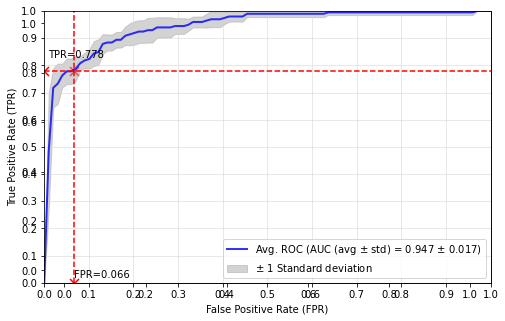


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.947 +/- 0.017
Accuracy (Avg. +/- Std.) is  0.885 +/- 0.018
Avg. CM is [[30, 5], [8, 81]]
Total for all folds CM is [[154, 29], [44, 409]]
Sensitivity (Avg. +/- Std.) is  0.778 +/- 0.048
Specificity (Avg. +/- Std.) is  0.934 +/- 0.022
Precision (Avg. +/- Std.) is  0.844 +/- 0.041
FOR (Avg. +/- Std.) is  0.097 +/- 0.019
DOR (Avg. +/- Std.) is  57.386 +/- 22.498


In [26]:
i=6
Accuracy = []                                                                
FP = []                                                                     
TN = []                                                                     
FN = []                                                                    
TP = []                                                                     
tprs = []                                                                   
aucs_ens = []                                                                
sn = []                                                                     
sp = []                                                                     
pr = []                                                                      
FOR = []                                                                   
DOR = []                                                                    
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))



for train_index, test_index in kf.split(X_Data,Y_Lavel):                    

    X_Train, X_Test = X_Data[train_index], X_Data[test_index]               
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]             

    clf = Ensembler( i, X_Train, Y_Train.ravel(), X_Test, Y_Test.ravel(), 'None')           

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),           
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_ens.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                             
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    sn.append(tp/(tp+fn))
    sp.append(tn/(fp+tn))
    pr.append(tp/(tp+fp))
    FOR.append(fn/(tn+fn))
    DOR.append((tp*tn)/(fp*fn))

average_ROC(mean_fpr,tprs,aucs_ens,TP,TN,FP,FN)                             
average_performance(aucs_ens,Accuracy,TP,TN,FP,FN)                          

print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))

### Analyzing AB + XB + LGBM

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        88
           1       0.91      0.78      0.84        40

    accuracy                           0.91       128
   macro avg       0.91      0.87      0.89       128
weighted avg       0.91      0.91      0.90       128


Area Under ROC (AUC): 0.9451704545454546

Confusion Matrix for current fold: 
[[85  3]
 [ 9 31]]

Accuracy for Current Fold: 0.90625

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        87
           1       0.81      0.75      0.78        40

    accuracy                           0.87       127
   macro avg       0.85      0.83      0.84       127
weighted avg       0.86      0.87      0.86       127


Area Und

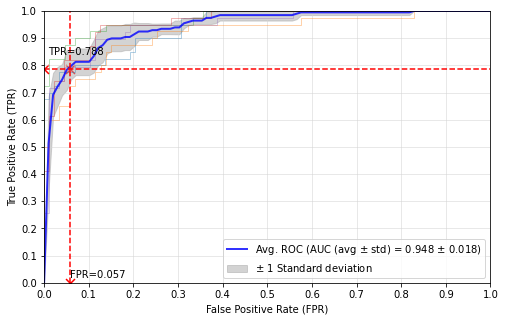


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.948 +/- 0.018
Accuracy (Avg. +/- Std.) is  0.895 +/- 0.019
Avg. CM is [[31, 5], [8, 82]]
Total for all folds CM is [[156, 25], [42, 413]]
Sensitivity (Avg. +/- Std.) is  0.788 +/- 0.041
Specificity (Avg. +/- Std.) is  0.943 +/- 0.029
Precision (Avg. +/- Std.) is  0.866 +/- 0.056
FOR (Avg. +/- Std.) is  0.092 +/- 0.016
DOR (Avg. +/- Std.) is  78.865 +/- 34.951


In [ ]:
from sklearn.ensemble import VotingClassifier
i=9
Accuracy = []                                                               
FP = []                                                                      
TN = []                                                                      
FN = []                                                                     
TP = []                                                                      
tprs = []                                                                   
aucs_ens = []                                                                
sn = []                                                                     
sp = []                                                                     
pr = []                                                                     
FOR = []                                                                     
DOR = []                                                                     
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))



for train_index, test_index in kf.split(X_Data,Y_Lavel):                    

    X_Train, X_Test = X_Data[train_index], X_Data[test_index]               
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]             

    clf = Ensembler( i, X_Train, Y_Train.ravel(), X_Test, Y_Test.ravel(), 'None')          

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),          
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_ens.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                             
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    sn.append(tp/(tp+fn))
    sp.append(tn/(fp+tn))
    pr.append(tp/(tp+fp))
    FOR.append(fn/(tn+fn))
    DOR.append((tp*tn)/(fp*fn))

average_ROC(mean_fpr,tprs,aucs_ens,TP,TN,FP,FN)                             
average_performance(aucs_ens,Accuracy,TP,TN,FP,FN)                         
print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))



### Analyzing XB + LBGM

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        88
           1       0.91      0.78      0.84        40

    accuracy                           0.91       128
   macro avg       0.91      0.87      0.89       128
weighted avg       0.91      0.91      0.90       128


Area Under ROC (AUC): 0.9457386363636364

Confusion Matrix for current fold: 
[[85  3]
 [ 9 31]]

Accuracy for Current Fold: 0.90625

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        87
           1       0.81      0.75      0.78        40

    accuracy                           0.87       127
   macro avg       0.85      0.83      0.84       127
weighted avg       0.86      0.87      0.86       127


Area Und

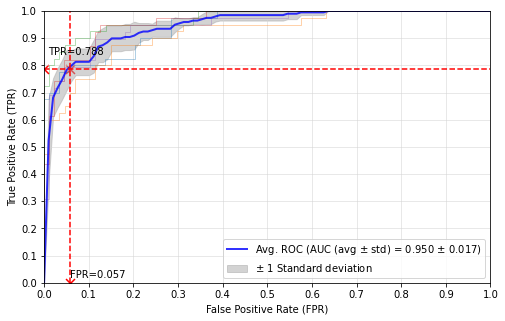


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.950 +/- 0.017
Accuracy (Avg. +/- Std.) is  0.895 +/- 0.019
Avg. CM is [[31, 5], [8, 82]]
Total for all folds CM is [[156, 25], [42, 413]]
Sensitivity (Avg. +/- Std.) is  0.788 +/- 0.041
Specificity (Avg. +/- Std.) is  0.943 +/- 0.029
Precision (Avg. +/- Std.) is  0.866 +/- 0.056
FOR (Avg. +/- Std.) is  0.092 +/- 0.016
DOR (Avg. +/- Std.) is  78.865 +/- 34.951


In [ ]:
from sklearn.ensemble import VotingClassifier
i=10
Accuracy = []                                                               
FP = []                                                                      
TN = []                                                                     
FN = []                                                                     
TP = []                                                                     
tprs = []                                                                   
aucs_ens = []                                                               
sn = []                                                                      
sp = []                                                                      
pr = []                                                                     
FOR = []                                                                     
DOR = []                                                                     
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))



for train_index, test_index in kf.split(X_Data,Y_Lavel):                    

    X_Train, X_Test = X_Data[train_index], X_Data[test_index]               
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]            


    clf = Ensembler( i, X_Train, Y_Train.ravel(), X_Test, Y_Test.ravel(), 'None')           

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),           
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_ens.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                            
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    sn.append(tp/(tp+fn))
    sp.append(tn/(fp+tn))
    pr.append(tp/(tp+fp))
    FOR.append(fn/(tn+fn))
    DOR.append((tp*tn)/(fp*fn))

average_ROC(mean_fpr,tprs,aucs_ens,TP,TN,FP,FN)                            
average_performance(aucs_ens,Accuracy,TP,TN,FP,FN)                          

print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))



### Analyzing XB + LGBM + RF

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        88
           1       0.91      0.78      0.84        40

    accuracy                           0.91       128
   macro avg       0.91      0.87      0.89       128
weighted avg       0.91      0.91      0.90       128


Area Under ROC (AUC): 0.9428977272727272

Confusion Matrix for current fold: 
[[85  3]
 [ 9 31]]

Accuracy for Current Fold: 0.90625

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        87
           1       0.83      0.75      0.79        40

    accuracy                           0.87       127
   macro avg       0.86      0.84      0.85       127
weighted avg       0.87      0.87      0.87       127


Area Und

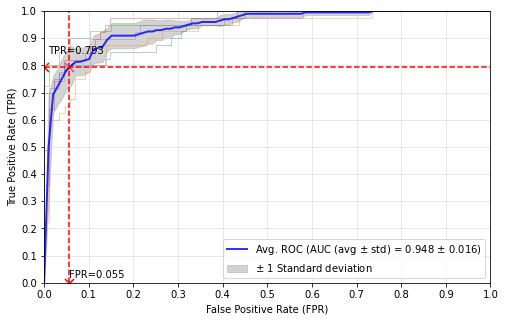


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.948 +/- 0.016
Accuracy (Avg. +/- Std.) is  0.898 +/- 0.019
Avg. CM is [[31, 4], [8, 82]]
Total for all folds CM is [[157, 24], [41, 414]]
Sensitivity (Avg. +/- Std.) is  0.793 +/- 0.046
Specificity (Avg. +/- Std.) is  0.945 +/- 0.027
Precision (Avg. +/- Std.) is  0.871 +/- 0.053
FOR (Avg. +/- Std.) is  0.090 +/- 0.018
DOR (Avg. +/- Std.) is  85.441 +/- 42.240


In [ ]:
i=11
Accuracy = []                                                               
FP = []                                                                      
TN = []                                                                    
FN = []                                                                      
TP = []                                                                     
tprs = []                                                                    
aucs_ens = []                                                               
sn = []                                                                     
sp = []                                                                     
pr = []                                                                     
FOR = []                                                                    
DOR = []                                                                    
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))



for train_index, test_index in kf.split(X_Data,Y_Lavel):                    

    X_Train, X_Test = X_Data[train_index], X_Data[test_index]               
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]             


    clf = Ensembler( i, X_Train, Y_Train.ravel(), X_Test, Y_Test.ravel(), 'None')           
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),          
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_ens.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                             
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    sn.append(tp/(tp+fn))
    sp.append(tn/(fp+tn))
    pr.append(tp/(tp+fp))
    FOR.append(fn/(tn+fn))
    DOR.append((tp*tn)/(fp*fn))

average_ROC(mean_fpr,tprs,aucs_ens,TP,TN,FP,FN)                            
average_performance(aucs_ens,Accuracy,TP,TN,FP,FN)                         

print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))



### Analyzing XB + LGBM + GBC

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        88
           1       0.91      0.75      0.82        40

    accuracy                           0.90       128
   macro avg       0.90      0.86      0.88       128
weighted avg       0.90      0.90      0.90       128


Area Under ROC (AUC): 0.9423295454545455

Confusion Matrix for current fold: 
[[85  3]
 [10 30]]

Accuracy for Current Fold: 0.8984375

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.88      0.91      0.89        87
           1       0.78      0.72      0.75        40

    accuracy                           0.85       127
   macro avg       0.83      0.82      0.82       127
weighted avg       0.85      0.85      0.85       127


Area U

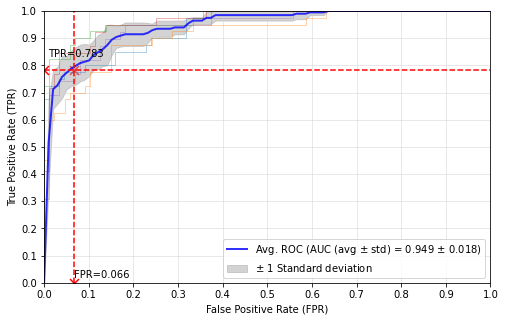


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.949 +/- 0.018
Accuracy (Avg. +/- Std.) is  0.887 +/- 0.021
Avg. CM is [[31, 5], [8, 81]]
Total for all folds CM is [[155, 29], [43, 409]]
Sensitivity (Avg. +/- Std.) is  0.783 +/- 0.046
Specificity (Avg. +/- Std.) is  0.934 +/- 0.023
Precision (Avg. +/- Std.) is  0.845 +/- 0.049
FOR (Avg. +/- Std.) is  0.095 +/- 0.019
DOR (Avg. +/- Std.) is  61.882 +/- 26.173


In [ ]:
from sklearn.ensemble import VotingClassifier
i=12
Accuracy = []                                                               
FP = []                                                                      
TN = []                                                                      
FN = []                                                                      
TP = []                                                                      
tprs = []                                                                    
aucs_ens = []                                                                
sn = []                                                                     
sp = []                                                                     
pr = []                                                                      
FOR = []                                                                    
DOR = []                                                                     
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))



for train_index, test_index in kf.split(X_Data,Y_Lavel):                   

    X_Train, X_Test = X_Data[train_index], X_Data[test_index]               
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]             

    clf = Ensembler( i, X_Train, Y_Train.ravel(), X_Test, Y_Test.ravel(), 'None')          

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),           
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_ens.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                            
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    sn.append(tp/(tp+fn))
    sp.append(tn/(fp+tn))
    pr.append(tp/(tp+fp))
    FOR.append(fn/(tn+fn))
    DOR.append((tp*tn)/(fp*fn))

average_ROC(mean_fpr,tprs,aucs_ens,TP,TN,FP,FN)                             
average_performance(aucs_ens,Accuracy,TP,TN,FP,FN)                          

print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))

In [ ]:
from sklearn.ensemble import VotingClassifier
i=12
Accuracy = []                                                               
FP = []                                                                      
TN = []                                                                      
FN = []                                                                      
TP = []                                                                      
tprs = []                                                                    
aucs_ens = []                                                                
sn = []                                                                     
sp = []                                                                     
pr = []                                                                      
FOR = []                                                                    
DOR = []                                                                     
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))



for train_index, test_index in kf.split(X_Data,Y_Lavel):                   

    X_Train, X_Test = X_Data[train_index], X_Data[test_index]               
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]             

    clf = Ensembler( i, X_Train, Y_Train.ravel(), X_Test, Y_Test.ravel(), 'None')          

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),           
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_ens.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                            
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    sn.append(tp/(tp+fn))
    sp.append(tn/(fp+tn))
    pr.append(tp/(tp+fp))
    FOR.append(fn/(tn+fn))
    DOR.append((tp*tn)/(fp*fn))

average_ROC(mean_fpr,tprs,aucs_ens,TP,TN,FP,FN)                             
average_performance(aucs_ens,Accuracy,TP,TN,FP,FN)                          

print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))